## Settings

In [1]:
setwd("~/git/hist_future_hail/")                             # Working directory.
source("modules/gev_functions.R")                            # Load helper functions.
variables = c("hailcast_diam_max", "wind_10m")               # Variables to process.
results_dir = "/g/data/up6/tr2908/hist_future_hail/results/" # Results directory.
set.seed(42)                                                 # Random seed for reproducibility.

## Read in data

In [2]:
all_dat = read_feathers(results_dir = results_dir)

[1] "/g/data/up6/tr2908/hist_future_hail/results//Adelaide_hist_block_maxima.feather"
[1] "/g/data/up6/tr2908/hist_future_hail/results//Adelaide_ssp245_block_maxima.feather"
[1] "/g/data/up6/tr2908/hist_future_hail/results//Brisbane_hist_block_maxima.feather"
[1] "/g/data/up6/tr2908/hist_future_hail/results//Brisbane_ssp245_block_maxima.feather"
[1] "/g/data/up6/tr2908/hist_future_hail/results//Kalgoorlie_hist_block_maxima.feather"
[1] "/g/data/up6/tr2908/hist_future_hail/results//Kalgoorlie_ssp245_block_maxima.feather"
[1] "/g/data/up6/tr2908/hist_future_hail/results//Melbourne_hist_block_maxima.feather"
[1] "/g/data/up6/tr2908/hist_future_hail/results//Melbourne_ssp245_block_maxima.feather"
[1] "/g/data/up6/tr2908/hist_future_hail/results//Perth_hist_block_maxima.feather"
[1] "/g/data/up6/tr2908/hist_future_hail/results//Perth_ssp245_block_maxima.feather"
[1] "/g/data/up6/tr2908/hist_future_hail/results//Sydney_Canberra_hist_block_maxima.feather"
[1] "/g/data/up6/tr2908/hist_future_h

## Timeseries of maxima

First the timeseries of daily hail diameter maxima.

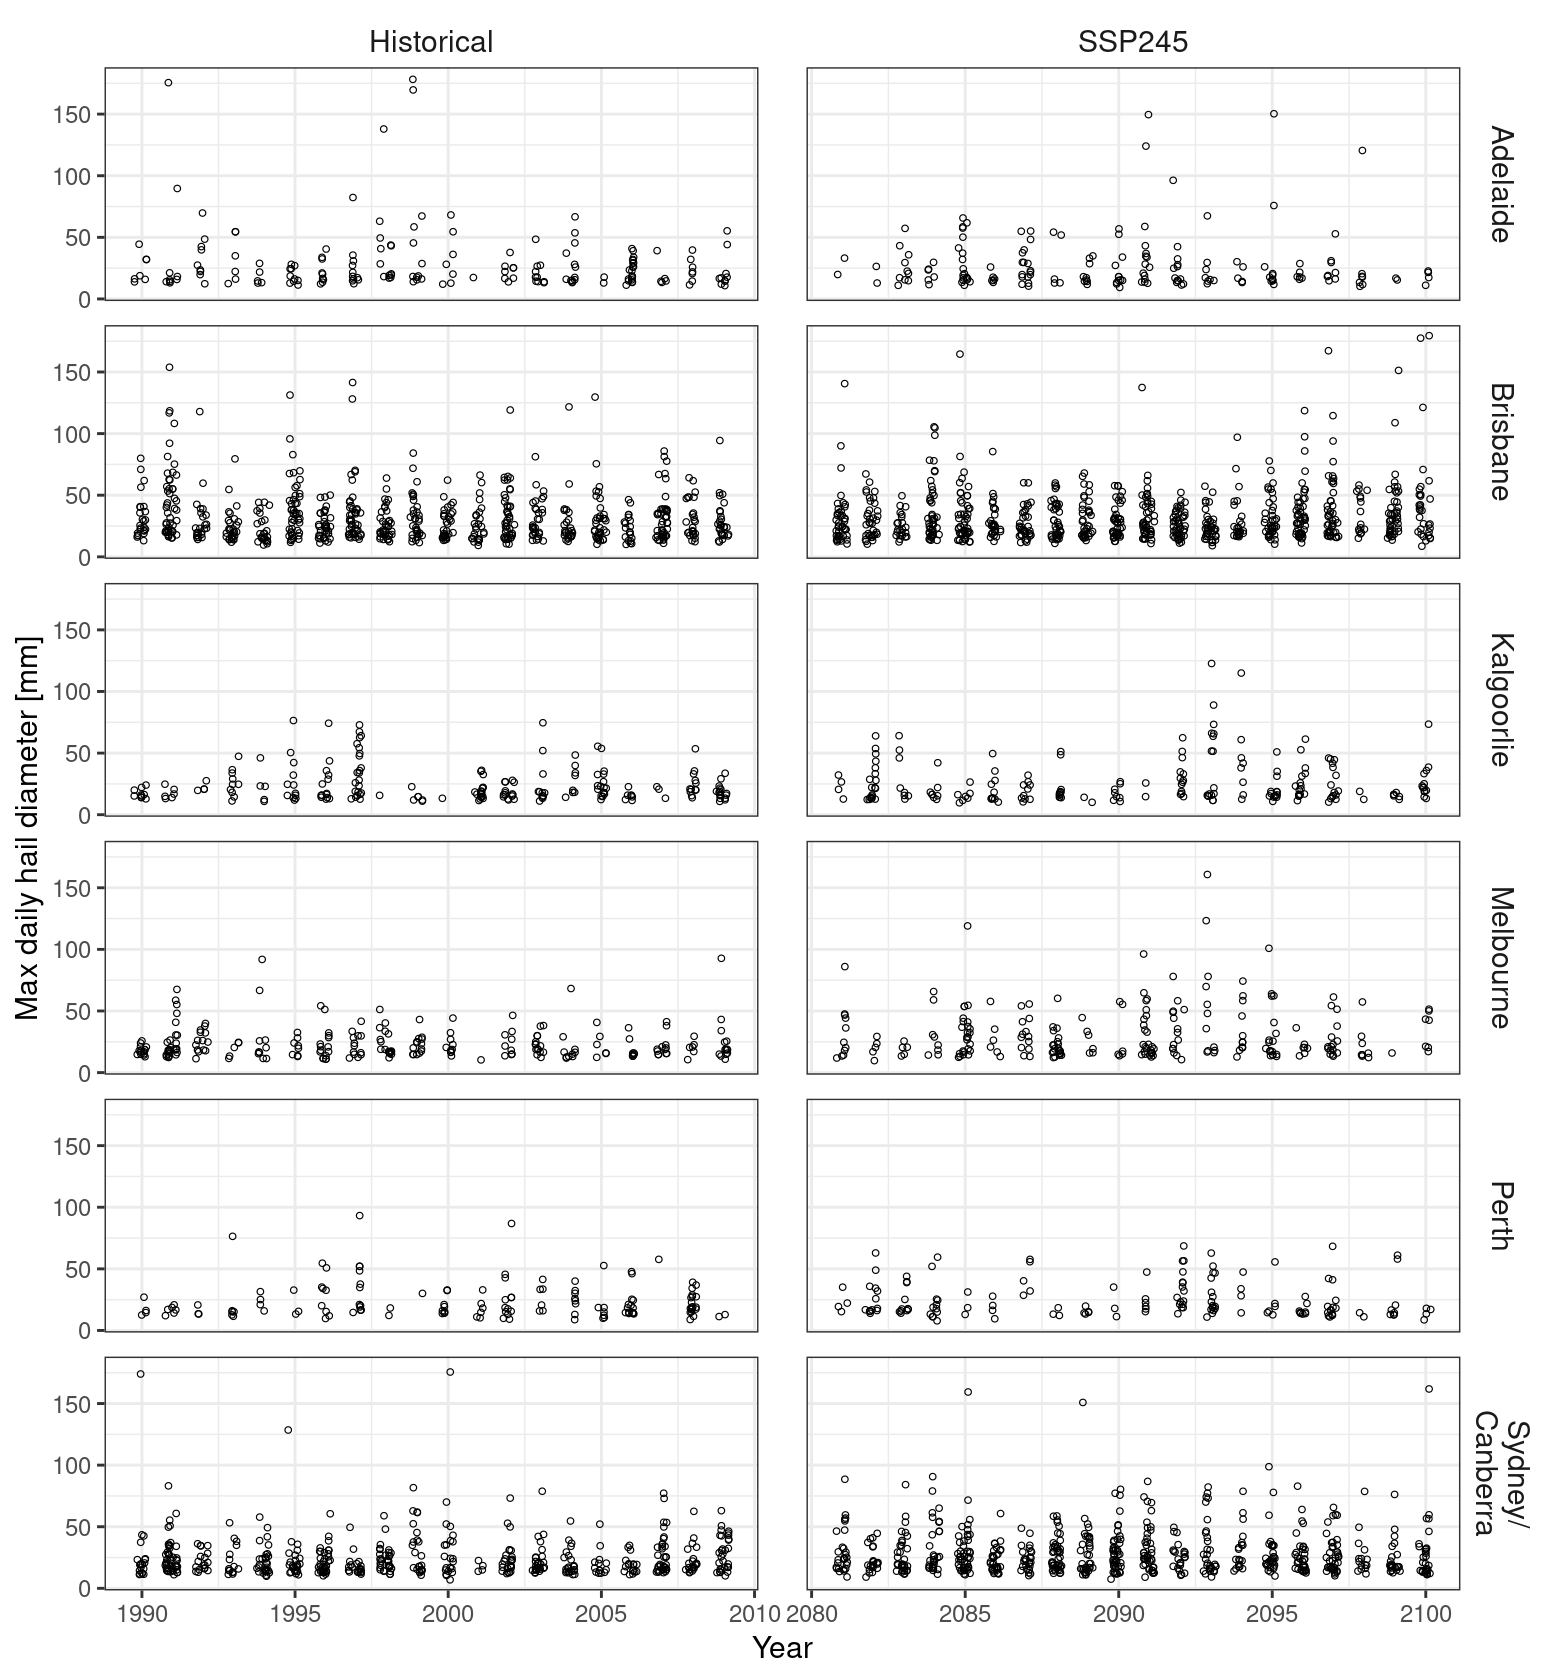

In [16]:
source("modules/gev_functions.R")
options(repr.plot.width = 13, repr.plot.height = 14)
plot_ts(
    dat = all_dat, ylabel = "Max daily hail diameter [mm]", var = "hailcast_diam_max",
    file = "paper/figures/timeseries_hail.pdf"
)

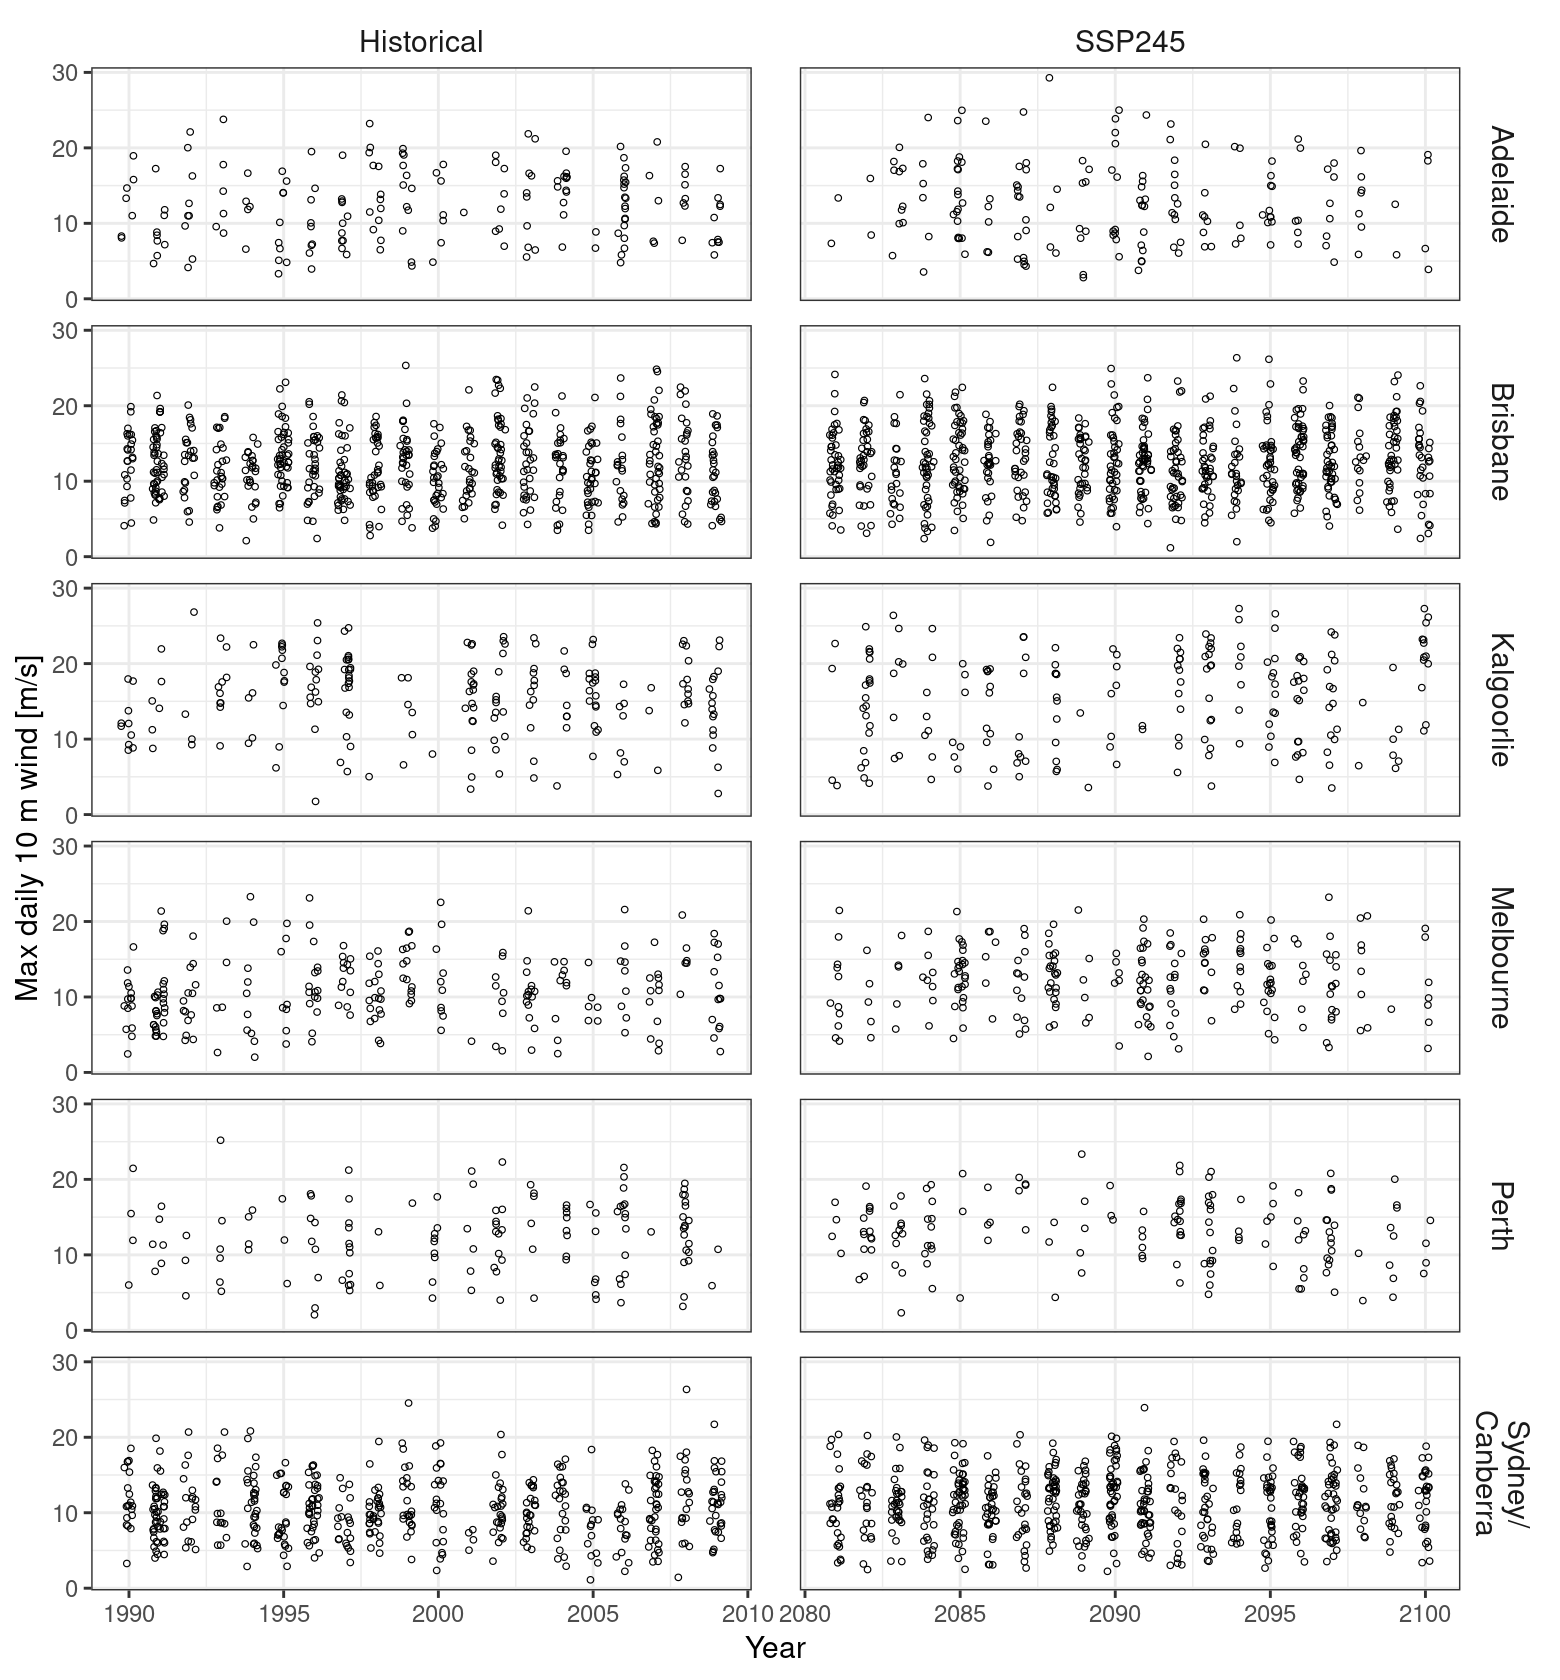

In [17]:
plot_ts(
    dat = all_dat, ylabel = "Max daily 10 m wind [m/s]", var = "wind_10m",
    file = "paper/figures/timeseries_wind.pdf"
)

## GEV fitting

In [5]:
gev_fits = fit_gevs(all_dat = all_dat)

[1] "Fitting for hailcast_diam_max in Adelaide for historical"
[1] "Fitting for hailcast_diam_max in Adelaide for ssp245"
[1] "Fitting for wind_10m in Adelaide for historical"
[1] "Fitting for wind_10m in Adelaide for ssp245"
[1] "Fitting for hailcast_diam_max in Brisbane for historical"
[1] "Fitting for hailcast_diam_max in Brisbane for ssp245"
[1] "Fitting for wind_10m in Brisbane for historical"
[1] "Fitting for wind_10m in Brisbane for ssp245"
[1] "Fitting for hailcast_diam_max in Kalgoorlie for historical"
[1] "Fitting for hailcast_diam_max in Kalgoorlie for ssp245"
[1] "Fitting for wind_10m in Kalgoorlie for historical"
[1] "Fitting for wind_10m in Kalgoorlie for ssp245"
[1] "Fitting for hailcast_diam_max in Melbourne for historical"
[1] "Fitting for hailcast_diam_max in Melbourne for ssp245"
[1] "Fitting for wind_10m in Melbourne for historical"
[1] "Fitting for wind_10m in Melbourne for ssp245"
[1] "Fitting for hailcast_diam_max in Perth for historical"
[1] "Fitting for hailcas

Warning message in ks.test.default(rextRemes(gevs[[d]][[v]][["historical"]], 1000), :
"p-value will be approximate in the presence of ties"


Plot parameters and their confidence intervals of each model in historic and ssp245 epochs; we consider two models significantly different if at least one parameter has non-overlapping confidence intervals.

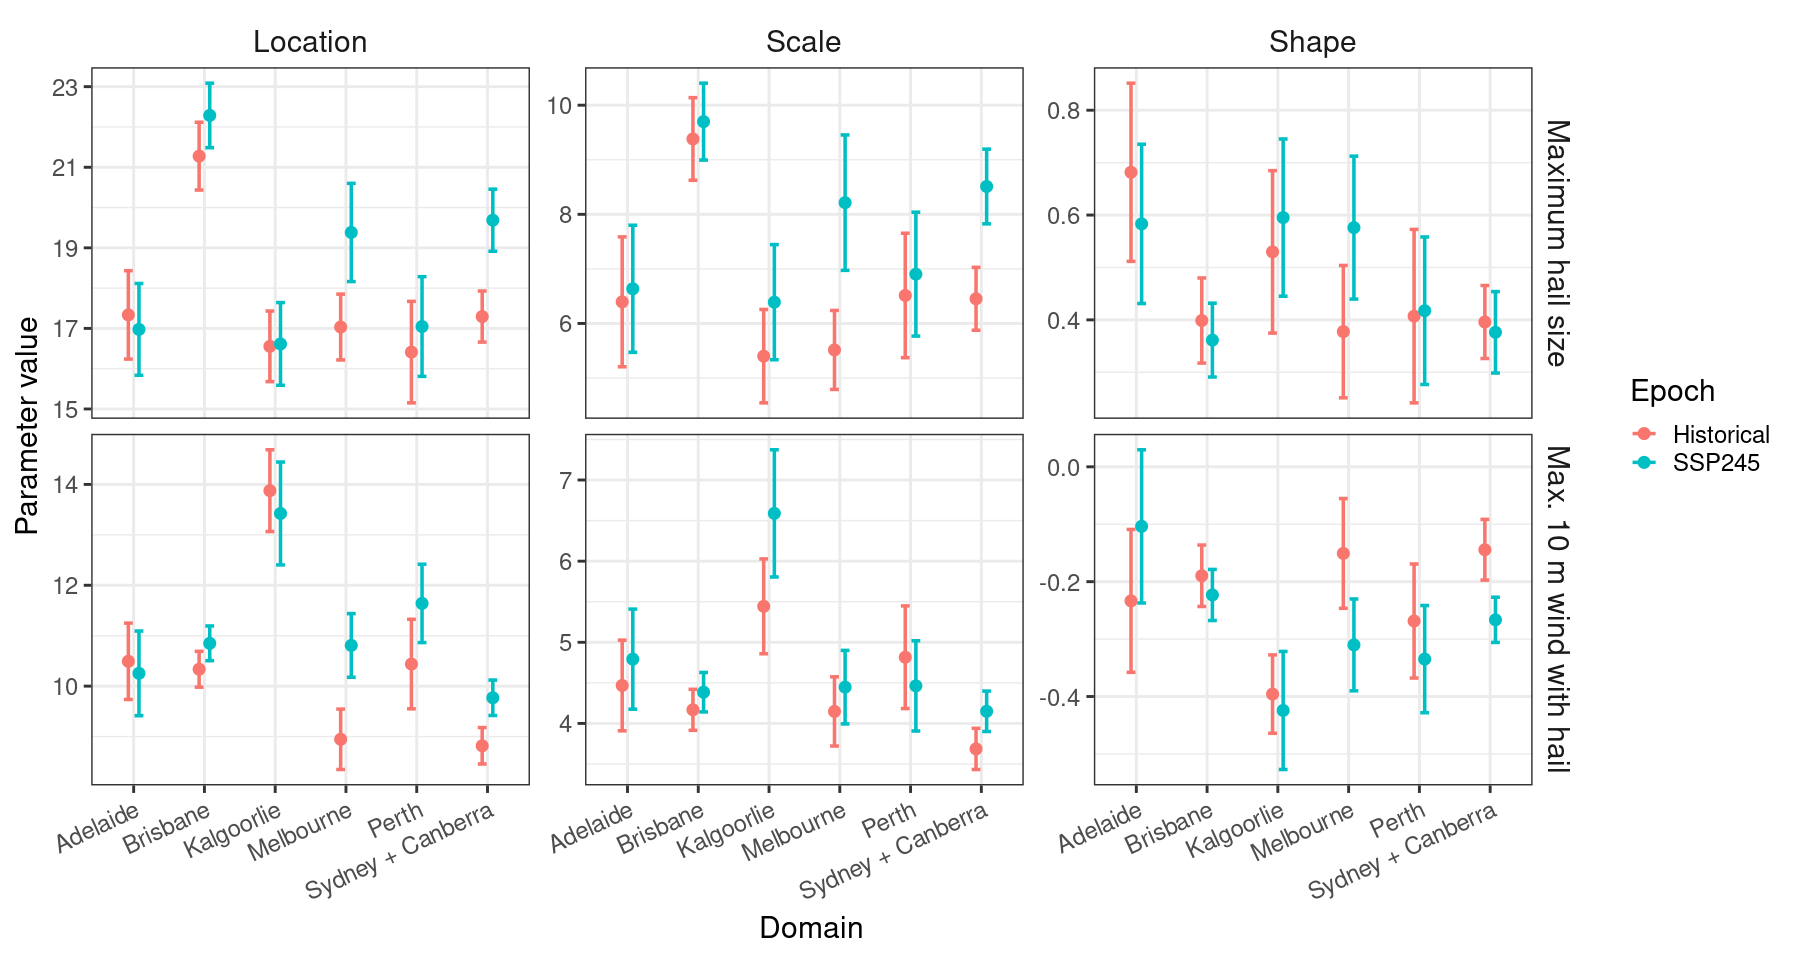

In [6]:
options(repr.plot.width = 15, repr.plot.height = 8)
plot_params(gev_fits = gev_fits, file = "paper/figures/fit_params.pdf")

We use the KS test to see whether a) the model and empirical data are from different distributions, and b) whether the historic vs ssp245 models are considered significantly different. For each comparison we draw 1000 points from the modelled distribution(s) and do the KS test 100 times to get a distribution of p values. If most p values are below 0.05 then the null hypothesis that the two samples come from the same distribution can be rejected.

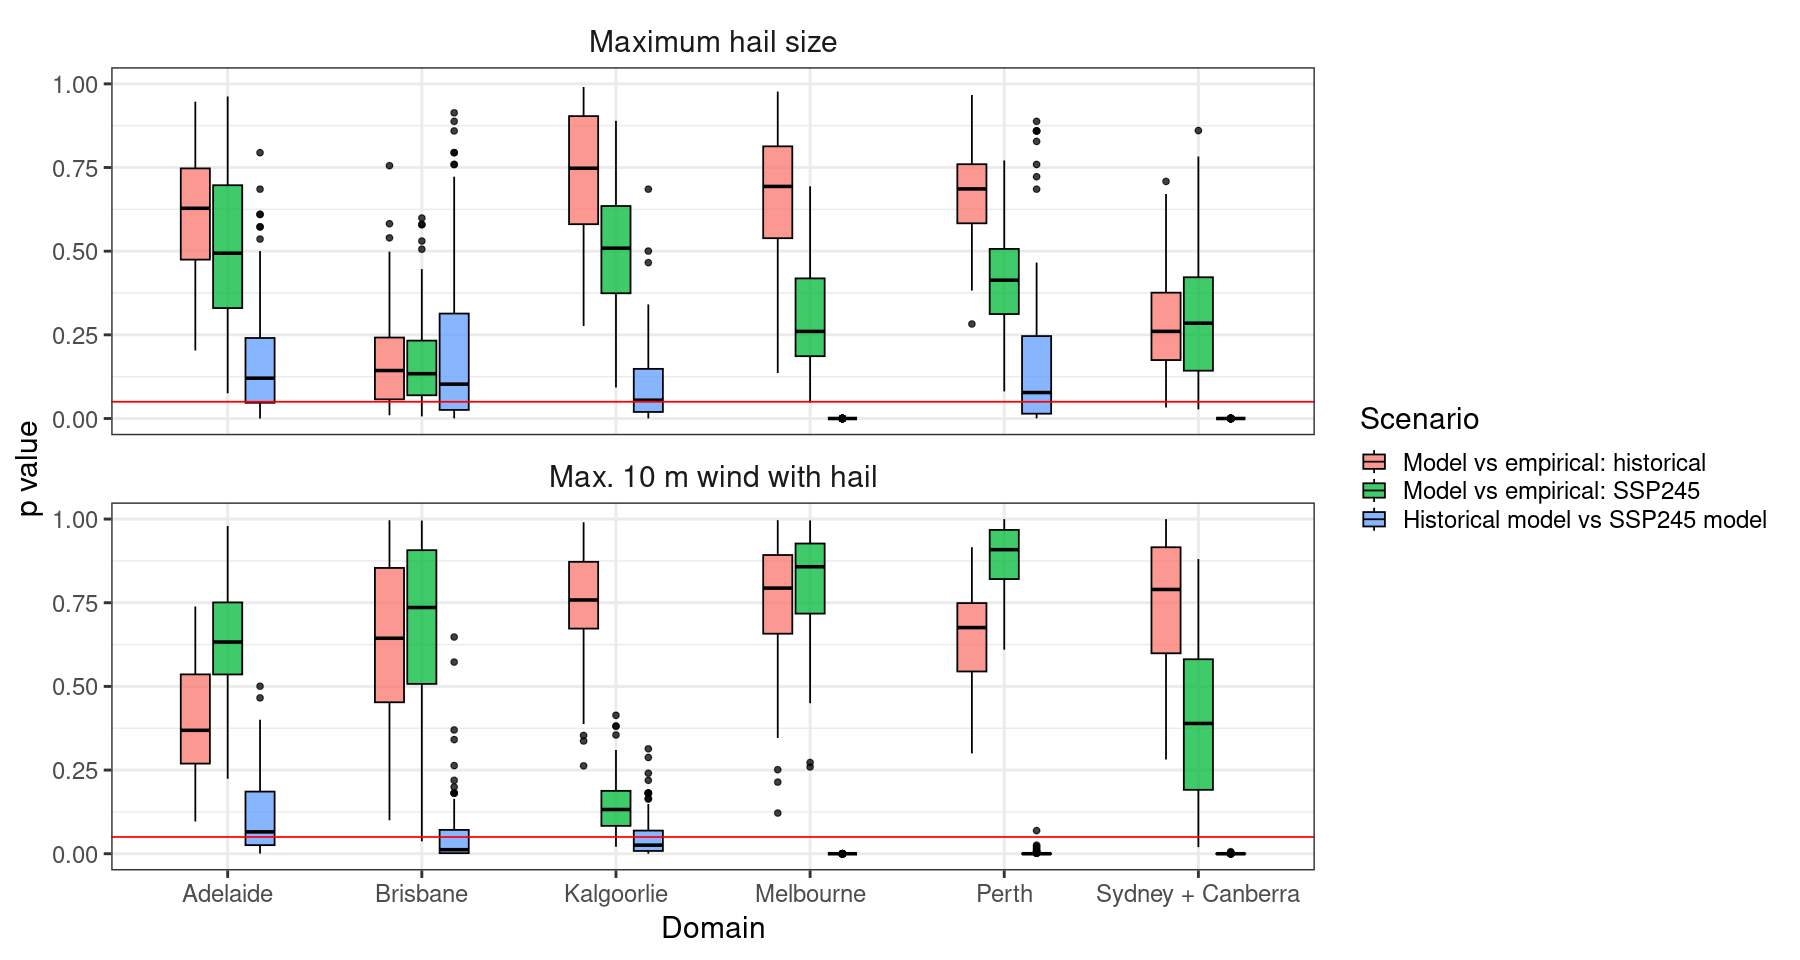

In [7]:
options(repr.plot.width = 15, repr.plot.height = 8)
plot_ks_fits(gev_fits = gev_fits, file = "paper/figures/fit_pvals.pdf")

QQ plots show goodness of fit between empirical and modelled values.

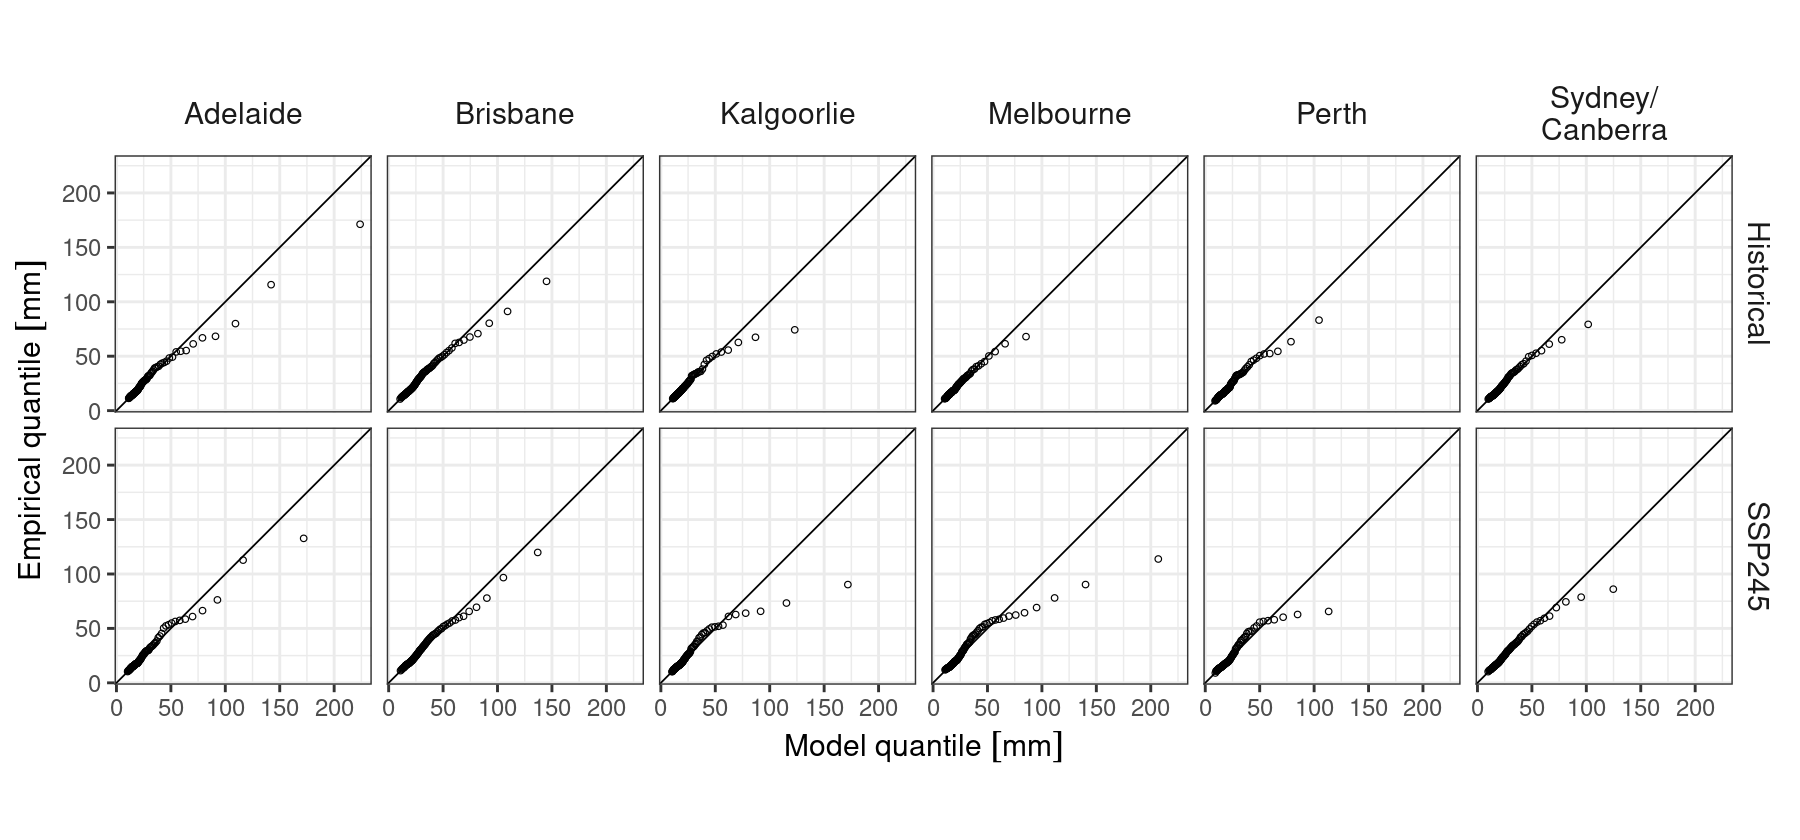

In [8]:
options(repr.plot.width = 15, repr.plot.height = 7)
plot_quantiles(gev_fits = gev_fits, var = "hailcast_diam_max", unit = "mm", file = "paper/figures/qq_hail.pdf")

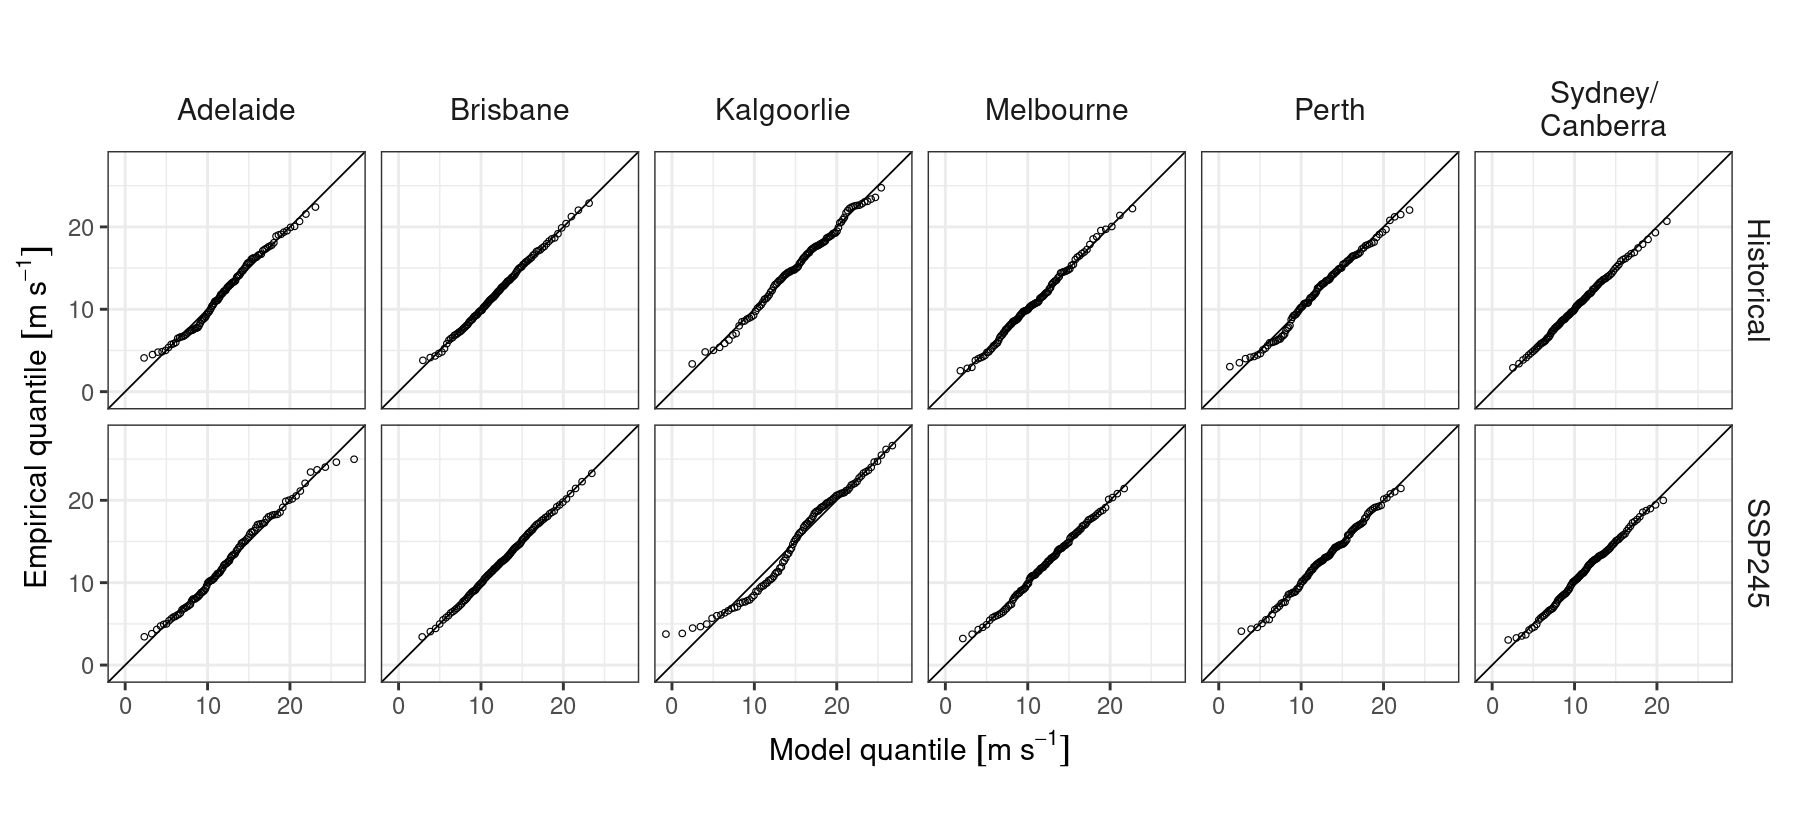

In [9]:
plot_quantiles(gev_fits = gev_fits, var = "wind_10m", unit = "m~s^{-1}", file = "paper/figures/qq_wind.pdf")

## Differences between historic and ssp245 models

Return periods in number of hail days (extRemes always says number of years but assumes each maxima is an annual maxima). Note return levels may be nonphysical for long return periods.

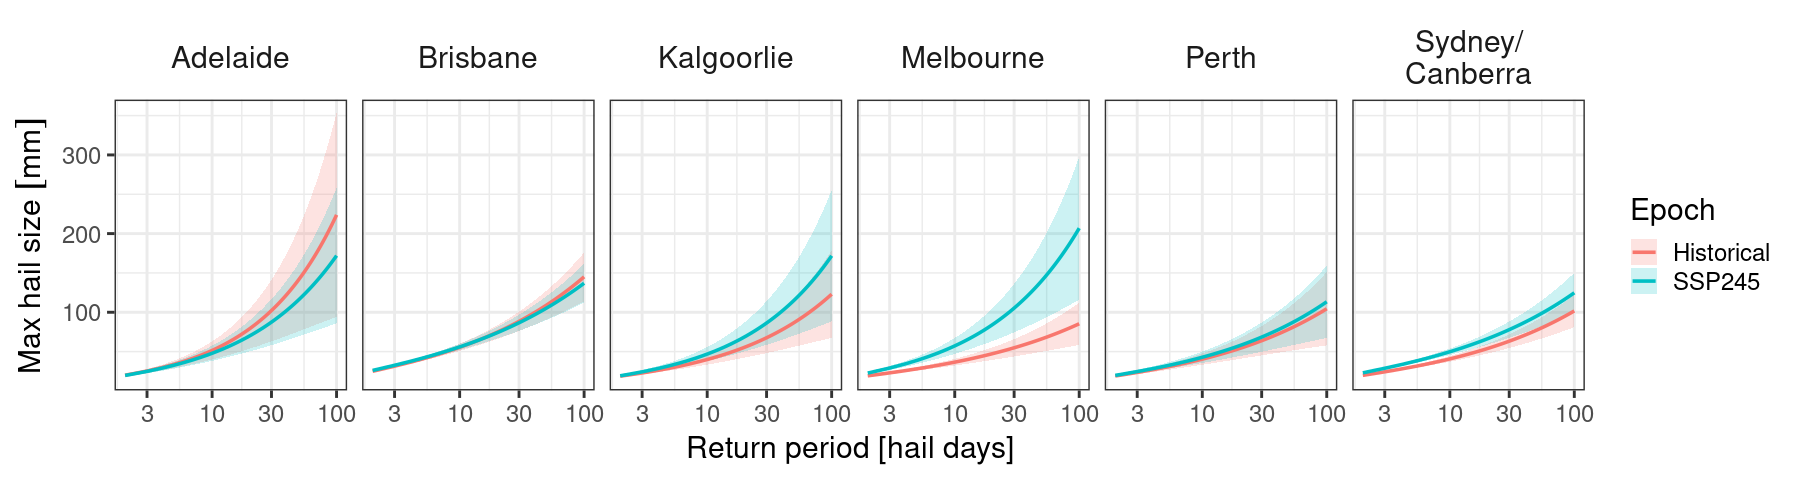

In [10]:
options(repr.plot.width = 15, repr.plot.height = 4)
plot_return_levels(
    gev_fits = gev_fits, var = "hailcast_diam_max",
    varname = "Max~hail~size~group('[',mm,']')",
    file = "paper/figures/return_periods_hail.pdf"
)

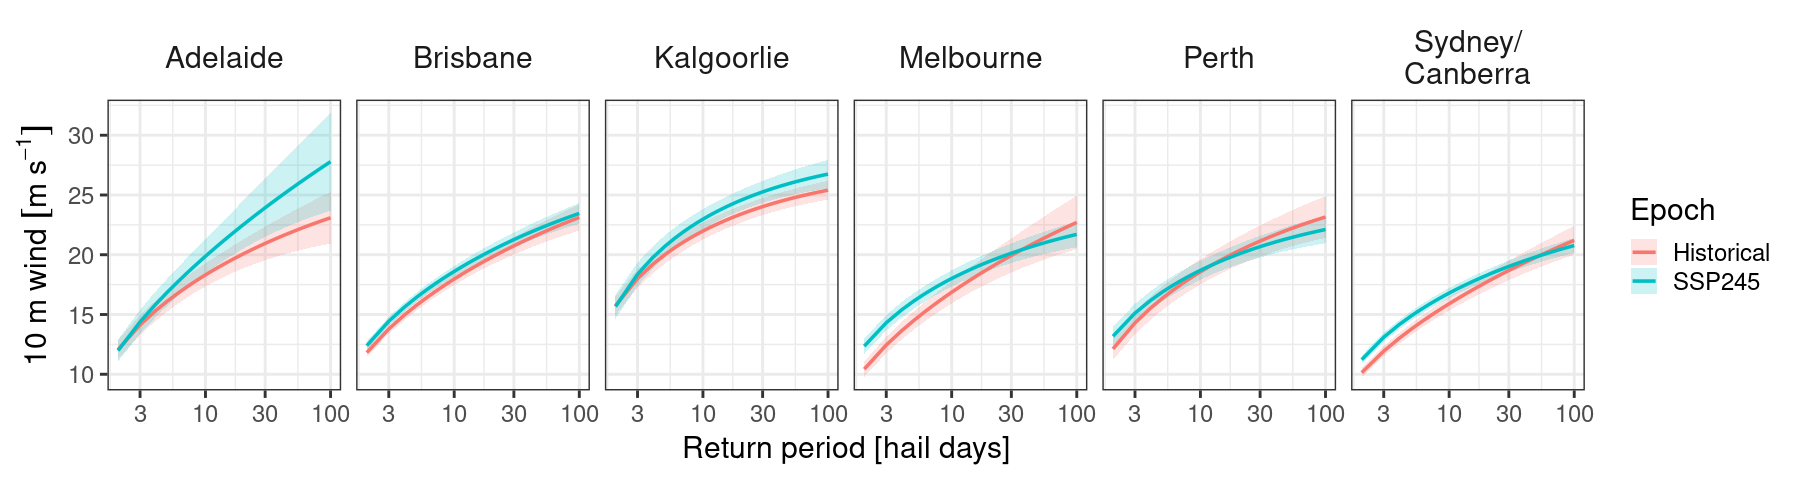

In [11]:
options(repr.plot.width = 15, repr.plot.height = 4)
plot_return_levels(
    gev_fits = gev_fits, var = "wind_10m",
    varname = "10~m~wind~group('[',m~s^{-1},']')", file = "paper/figures/return_periods_wind.pdf"
)

Look at probabilities of given levels occurring in a given hail day.

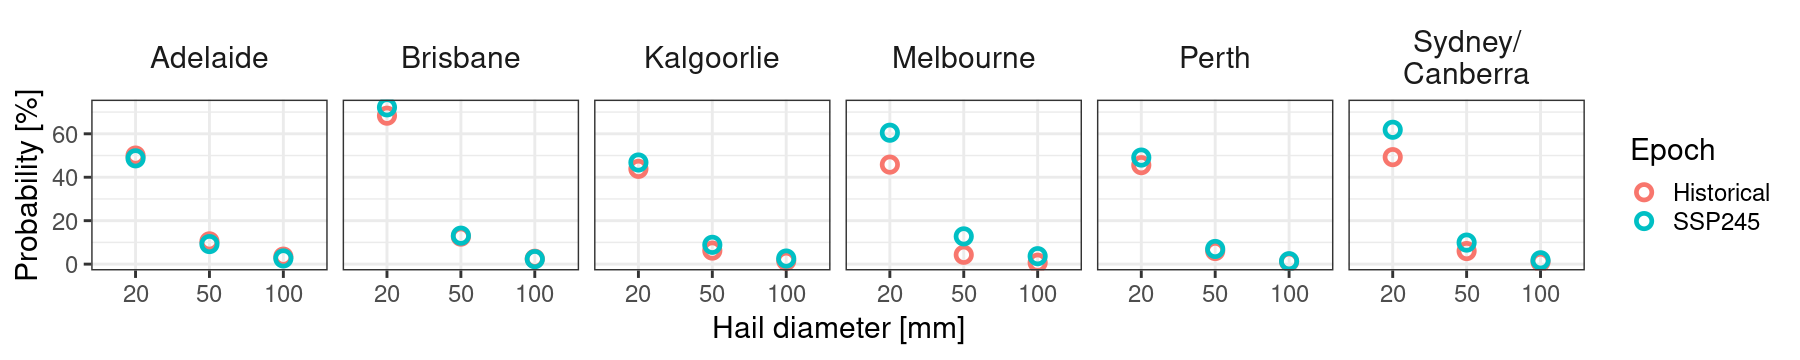

In [12]:
options(repr.plot.width = 15, repr.plot.height = 3)
plot_hail_probs(gev_fits = gev_fits, file = "paper/figures/hail_probs.pdf")

In [13]:
# Write outputs for display in paper.
write_feather(gev_fits$hail_probs, "results/hail_probs.feather")
write_feather(gev_fits$wind_probs, "results/wind_probs.feather")

Show tables of probabilities for given levels.

In [14]:
probabilities_table(gev_fits = gev_fits, var = "hail_probs", units = "mm")

                                                            
                              Probability [\\%]             
 Domain            Epoch      20 mm             50 mm 100 mm
 Adelaide          Historical 50.0              10.5   3.4  
                   SSP245     48.7               9.2   2.6  
 Brisbane          Historical 68.3              12.6   2.5  
                   SSP245     72.2              13.1   2.3  
 Kalgoorlie        Historical 43.9               6.2   1.5  
                   SSP245     46.8               8.9   2.6  
 Melbourne         Historical 45.8               4.3   0.7  
                   SSP245     60.5              12.8   3.7  
 Perth             Historical 45.6               6.0   1.1  
                   SSP245     49.1               7.0   1.3  
 Sydney + Canberra Historical 49.3               6.0   1.0  
                   SSP245     61.9               9.9   1.8  


In [15]:
probabilities_table(gev_fits = gev_fits, var = "wind_probs", units = "m s-1")

                                         
 Domain            Epoch      27.78 m s-1
 Adelaide          Historical 5e-03      
                   SSP245     1e+00      
 Brisbane          Historical 2e-02      
                   SSP245     1e-02      
 Kalgoorlie        Historical 0e+00      
                   SSP245     2e-01      
 Melbourne         Historical 5e-02      
                   SSP245     0e+00      
 Perth             Historical 3e-04      
                   SSP245     0e+00      
 Sydney + Canberra Historical 8e-03      
                   SSP245     0e+00      
